#**Project for Deep Learning in Data Science**

I choose to perform Regression using TMDB Box Office Prediction dataset.  
First I will upload my dataset and do exploratory data analysis to see main characterstics of the data.

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import ast 
from tensorflow.keras.metrics import MeanSquaredLogarithmicError
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score,mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/Box_Office/train.csv",index_col=0,delimiter=',')



#**Exploratory Data Analysis** 

In [ ]:
df.shape

(3000, 22)

Dataset has 3000 samples with 22 features,one of them(revenue) is our dependent variable.

In [ ]:
df.head()

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


There is only 3 numerical features from raw dataset that can be used in input of the regression model

In [ ]:
df.describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


In [ ]:
print('Number of movies without budget:',len(df[df.budget==0]))
print('Number of movies withoutt runtime:',len(df[df.runtime==0]))

Number of movies without budget: 812
Number of movies withoutt runtime: 12


We can see that there are 12 movies with runtime equal 0 and 2 movies that don't have information about runtime so this 2 rows of values needs to be ommited for training process,or empty cells need to be artficially filled. Additionaly there are 812 movies with 0 budget.That might cause the problem during predicting new values from the unknown set because this is around 25% of the whole dataset and acording to the reality most movies have a budget.

<Figure size 720x576 with 0 Axes>

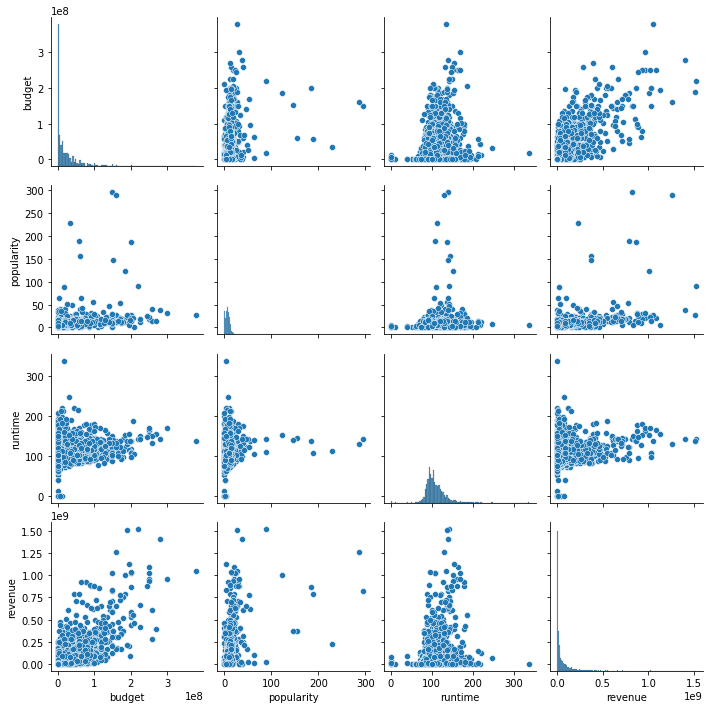

In [ ]:
plt.figure(figsize=(10, 8))
sns.pairplot(data=df)



Distribution of all features is right skewed. Now we will check how many missing values does our set have.

In [ ]:
 df.isna().sum().sort_values(ascending=False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
title                       0
imdb_id                     0
budget                      0
popularity                  0
original_language           0
original_title              0
status                      0
release_date                0
revenue                     0
dtype: int64

In [ ]:
print('Number of rows with at least one empty cell:',len(df)-len(df.dropna()))

Number of rows with at least one empty cell: 2797


In [ ]:
df.dropna(subset=['runtime'],inplace=True) # removing two rows with empty runtime values so they won't interupt further learning process

Now we should check performance for simple linear regression model using our data to check if it works properly. If not we have to transform our dataset to be more sophisticated for regression problem.

In [ ]:
train_dataset,test_dataset = train_test_split(df[df.describe().columns], test_size=0.2, random_state=42)

In [ ]:
train_x = train_dataset.copy()
train_y = train_x.pop('revenue')

test_x = test_dataset.copy()
test_y = test_x.pop('revenue')

scaler1=StandardScaler() # making same scale for every variable.
train_x=scaler1.fit_transform(train_x)
test_x=scaler1.transform(test_x)

scaler2=StandardScaler() 
train_y=scaler2.fit_transform(train_y.values.reshape(-1,1))
test_y=scaler2.transform(test_y.values.reshape(-1,1))



In [ ]:
regression_model1 = tf.keras.Sequential([                           
    layers.Dense(units=32,activation='relu'),
    layers.Dense(units=16,activation='relu'),
    layers.Dense(units=8,activation='relu'),  
    layers.Dense(units=1)
])

In [ ]:
regression_model1.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error', metrics=[MeanSquaredLogarithmicError()])

In [ ]:
history1 = regression_model1.fit(
    train_x, train_y,
    epochs=100,
    verbose=1,
    validation_split = 0.2)

Epoch 1/100
60/60 [==============================] - 1s 4ms/step - loss: 0.4426 - mean_squared_logarithmic_error: 0.0610 - val_loss: 0.3795 - val_mean_squared_logarithmic_error: 0.0611
Epoch 2/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3374 - mean_squared_logarithmic_error: 0.0544 - val_loss: 0.3723 - val_mean_squared_logarithmic_error: 0.0624
Epoch 3/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3380 - mean_squared_logarithmic_error: 0.0524 - val_loss: 0.3698 - val_mean_squared_logarithmic_error: 0.0600
Epoch 4/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3902 - mean_squared_logarithmic_error: 0.0562 - val_loss: 0.3931 - val_mean_squared_logarithmic_error: 0.0624
Epoch 5/100
60/60 [==============================] - 0s 6ms/step - loss: 0.3451 - mean_squared_logarithmic_error: 0.0552 - val_loss: 0.4130 - val_mean_squared_logarithmic_error: 0.0707
Epoch 6/100
60/60 [==============================] - 0s 2ms/step - loss: 0.

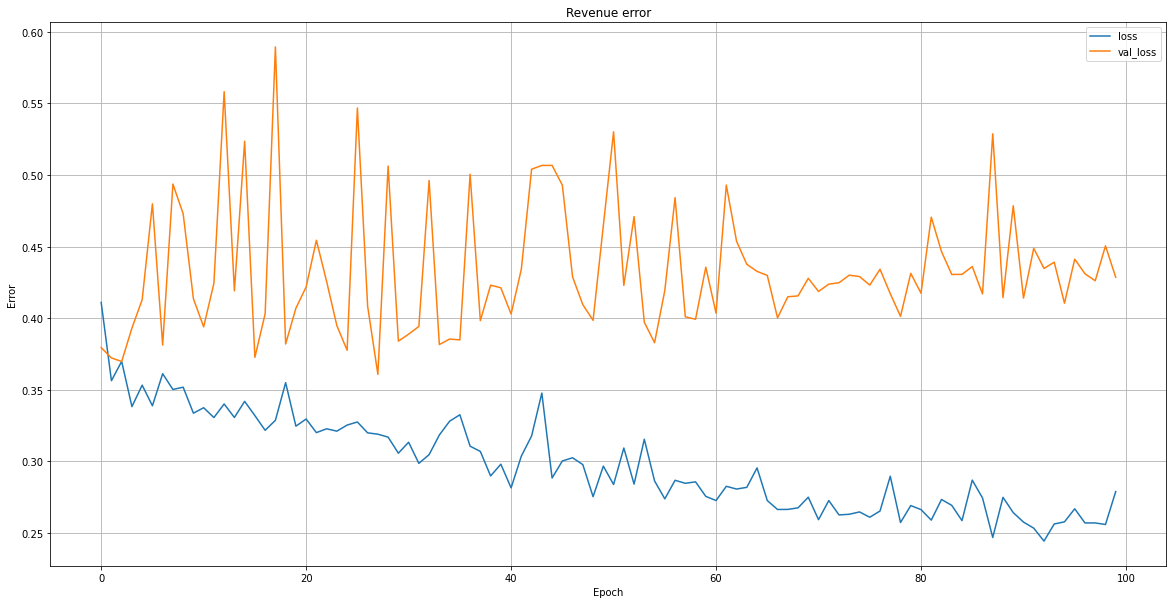

In [ ]:
def plot_loss(history1):
  plt.figure(figsize=(20,10))
  plt.plot(history1.history['loss'], label='loss')
  plt.plot(history1.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.title('Revenue error')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
 
plot_loss(history1)

In [ ]:
predictions = regression_model1.predict(test_x).flatten()

model_r2=r2_score(test_y,predictions)
model_MAE=mean_absolute_error(test_y,predictions)
model_RMSE=mean_squared_error(test_y,predictions,squared=False)

print('MAE=',mean_absolute_error(test_y,predictions))
print('RMSE=',mean_squared_error(test_y,predictions,squared=False))
print("R2=",r2_score(test_y,predictions))

MAE= 0.26996898973926536
RMSE= 0.46965235944673633
R2= 0.6788446624260558


Analyzing figure we can say that the model was unable to learn the training dataset at all. Validation line show noisy movement which might indicate that it is to small relative to training set. For the given dataset the main problem is very small number of the features(3) that can be used from this raw dataset in regression model.It might lead to underfitted model. Rest features are categorical data or other objects that can't be applied in regression problem. To use them we will need to perform some feature engineering to expand our set of independent variables. While doing this we will continue to analyze data.

# Feature engineering 

We will focus for each column one by one to check if it could be used further.

Genre, we will use only the number of occured genres.

In [ ]:
df.genres=df.genres.apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else [])) #extracting genres
 

Then i consider each genre as 1 and the final value was sum number of each movie genre.

In [ ]:
df.genres=df.genres.apply(len)


In [ ]:
df.genres.value_counts()

2    972
3    900
1    591
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

Most movies has 2 or 3 generes.

Belong to collection. Here we will binarize values and replace old ones. If movie belong tocollection it will be 1 else 0.

In [ ]:
df['belongs_to_collection'] = np.where(df['belongs_to_collection'].isna(), 0, 1)

For homepage we will process in the same way as in belong_to_collection feature.

In [ ]:
df['homepage'] = np.where(df['homepage'].isna(), 0, 1)

Now focus will be on features that can't be extracted or won't give us any special information. Suggested columns are: imdb_id and poster_path. First is just id that is no informative at all,second column is just the path to some jpg file.To not including them we will simply drop it.

In [ ]:
df.drop(['imdb_id','poster_path'],axis=1,inplace=True)

Next,we take a peak into language spoken in movies.

In [ ]:
df.original_language.value_counts()[:10] #most movies were taped in english


en    2575
fr      78
ru      46
es      43
hi      42
ja      37
it      24
ko      20
cn      20
zh      19
Name: original_language, dtype: int64

People eagerly watch movies with original english spoken language,thats why it is the most popular language in movies so we will use that knowledge to add new feature

In [ ]:
df['original_language']=np.where(df['original_language']=='en', 1, 0)

In [ ]:
df.spoken_languages=df['spoken_languages'].apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else [])) #extracting languages


In [ ]:
df.spoken_languages

id
1           [en]
2           [en]
3           [en]
4       [en, hi]
5           [ko]
          ...   
2996        [en]
2997        [sv]
2998        [en]
2999        [en]
3000        [en]
Name: spoken_languages, Length: 2998, dtype: object

In [ ]:
df['number_of_spoken_language']=df.spoken_languages.apply(len) #adding new feature

In [ ]:
df.number_of_spoken_language.value_counts()

1    2104
2     549
3     216
4      72
5      23
0      19
7       6
6       6
8       2
9       1
Name: number_of_spoken_language, dtype: int64

In [ ]:
df['spoken_languages_one_hot']=np.where(df['number_of_spoken_language']==1, 0, 1) 
# discretizize number of spoken language to the value of 0 if only one language is used,or 1 if more language are used,international movies has better quality 

Comparing original title with new title.We use value 1 if title are not equal or 0 if they are equal.Not equal mean that there wascreated remake or new adaptation.

In [ ]:
df['title_compare']=np.where(df['original_title'] == df['title'], 0, 1)
df.drop(['original_title','title','spoken_languages'],axis=1,inplace=True)


Now we take into account the production companies and countries.The most popular companies which producet larger number of movies will be better knoww and thus will earn more. 

In [ ]:
df.production_companies=df['production_companies'].apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else [])) #extracting languages
df['production_companies']=df.production_companies.apply(len)

In [ ]:
df.production_countries=df['production_countries'].apply(lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else [])) #extracting languages
df['production_countries']=df.production_countries.apply(len)

In [ ]:
df['production_countries']

id
1       1
2       1
3       1
4       1
5       1
       ..
2996    1
2997    2
2998    1
2999    1
3000    1
Name: production_countries, Length: 2998, dtype: int64

Another aspects are date and status.For status I will use one-hot encoding and for date i will split into so countable values like year month and day and then there will be time to analyze it acording to revenues.

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'], format='%m/%d/%y')
df['year'] =  df['release_date'].dt.year
df['month'] = df['release_date'].dt.month
df['day'] = df['release_date'].dt.day
df['day_of_week']=df['release_date'].dt.dayofweek 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


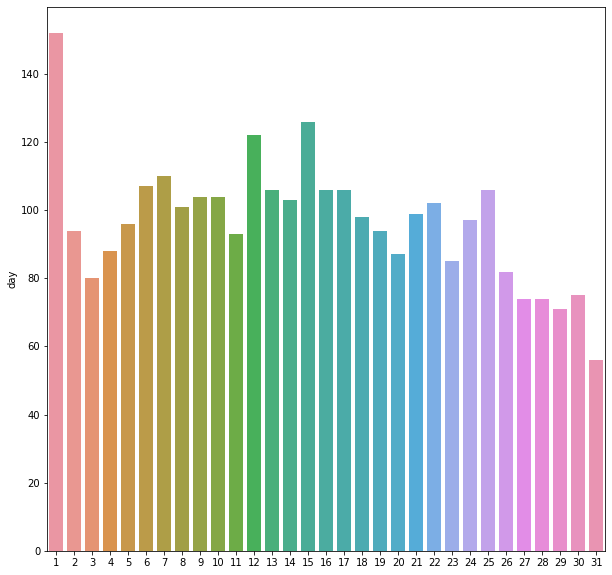

In [ ]:
plt.figure(figsize=(10, 10))
sns.barplot(df['day'].value_counts().sort_index().index,df['day'].value_counts().sort_index())


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


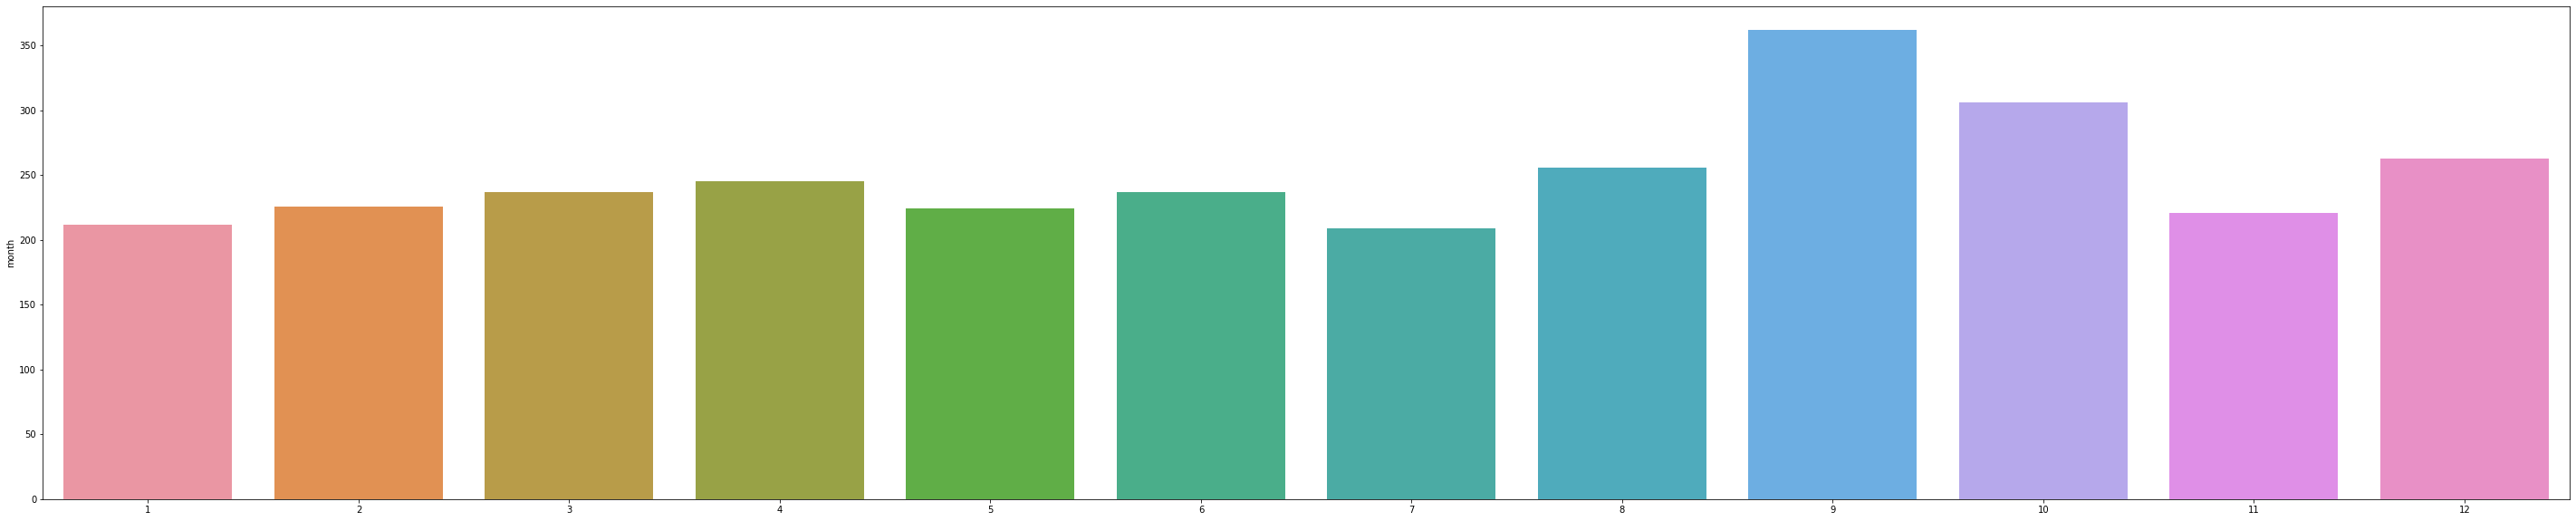

In [ ]:
plt.figure(figsize=(50, 10))
sns.barplot(df['month'].value_counts().sort_index().index,df['month'].value_counts().sort_index())

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


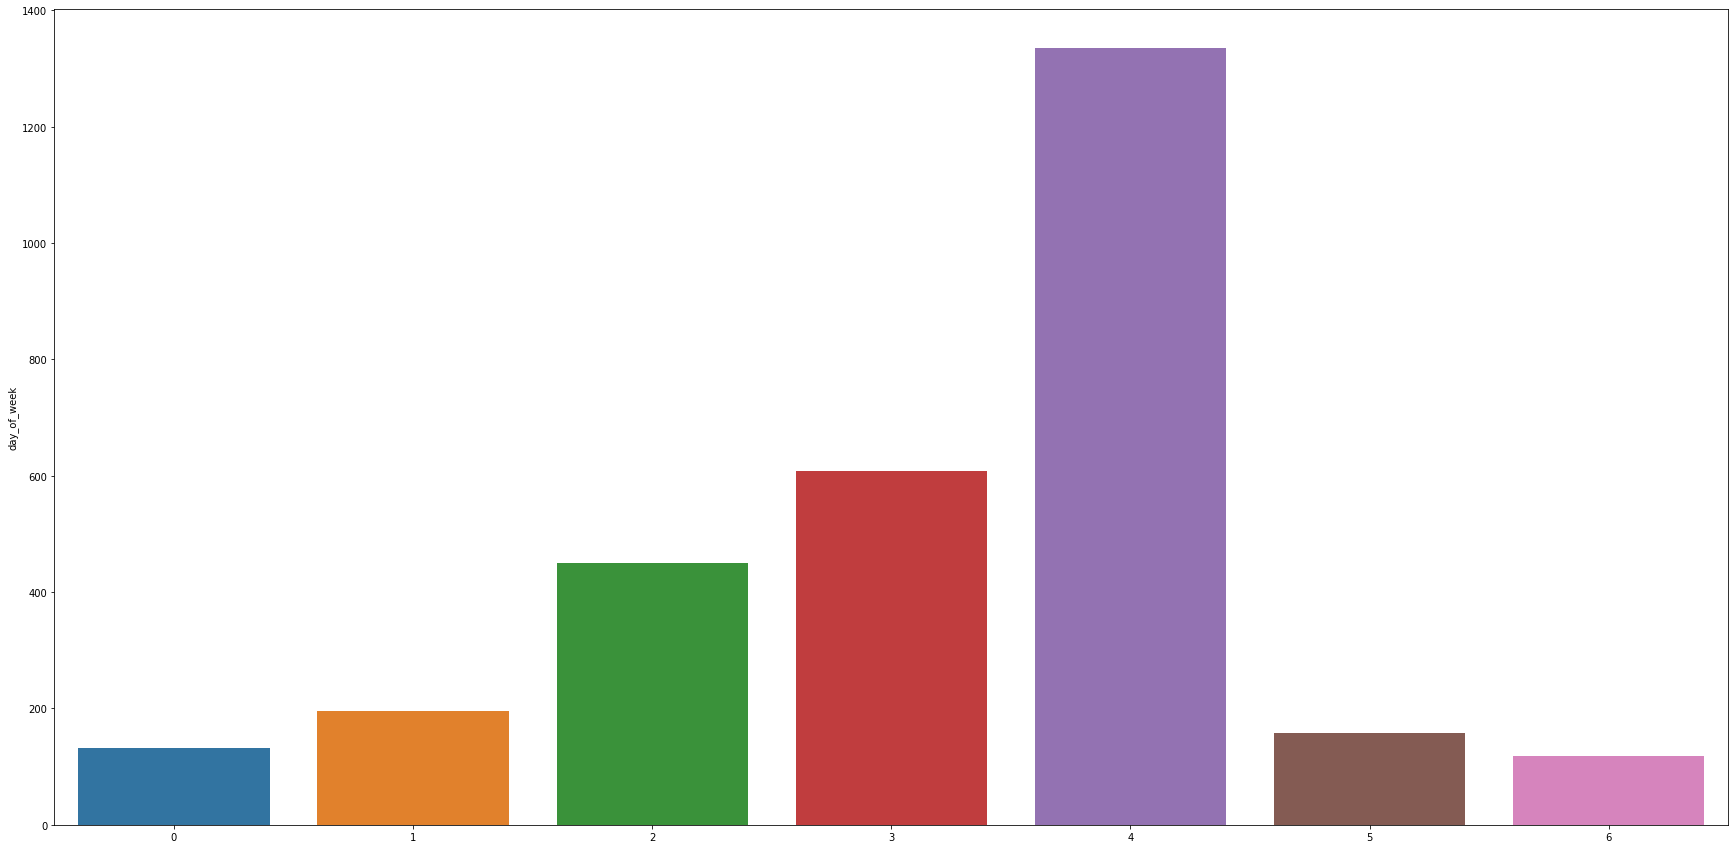

In [ ]:
plt.figure(figsize=(30, 15))
sns.barplot(df['day_of_week'].value_counts().sort_index().index,df['day_of_week'].value_counts().sort_index())

Lets perform one hot encoding for day of week,month and year

In [ ]:
dummies_month=pd.get_dummies(df['month'],prefix='month')
dummies_weekday=pd.get_dummies(df['day_of_week'],prefix='weekday')
dummies_year=pd.get_dummies(df['year'],prefix='year')

In [ ]:
df = pd.concat([df, dummies_month], axis = 1)
df = pd.concat([df, dummies_weekday], axis = 1)
df = pd.concat([df, dummies_year], axis = 1)

In [ ]:
df['status']=np.where(df['status']=='Released', 1, 0)

Next feature istagline which has more than 500 empty cells. IT is good to binirize this problem.

In [ ]:
df['tagline'] = np.where(df['tagline'].isna(), 0, 1)

Features like overview and keywords will be dropped due to lack of idea how to add it.

In [ ]:
df.drop(['Keywords','overview'],axis=1,inplace=True)

Last two feature are cast and crew of the movie.For that variables we will count how many people work in the movie.

In [ ]:
df.cast=df['cast'].apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else [])) #extracting languages
df['cast']=df.cast.apply(len)

In [ ]:
df.crew=df['crew'].apply(lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else [])) #extracting languages
df['crew']=df.crew.apply(len)

In [ ]:
df.drop(['year'],axis=1,inplace=True)

In [ ]:
print("Final dataset has",df.shape[1],'features.')

Final dataset has 130 features.


Now it is time to check if our new model will be better than one with only 3 independent variables.

In [ ]:
train_dataset,test_dataset = train_test_split(df[df.describe().columns], test_size=0.2, random_state=42)

In [ ]:
train_x2 = train_dataset.copy()
train_y2 = train_x2.pop('revenue')

test_x2 = test_dataset.copy()
test_y2 = test_x2.pop('revenue')

scaler1=StandardScaler() # making same scale for every variable.
train_x2=scaler1.fit_transform(train_x2)
test_x2=scaler1.transform(test_x2)

scaler2=StandardScaler() 
train_y2=scaler2.fit_transform(train_y2.values.reshape(-1,1))
test_y2=scaler2.transform(test_y2.values.reshape(-1,1))


In [ ]:
regression_model2 = tf.keras.Sequential([                           
    layers.Dense(units=32,activation='relu'),
    layers.Dense(units=16,activation='relu'),
    layers.Dense(units=8,activation='relu'),     
    layers.Dense(units=1)
])

In [ ]:
regression_model2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error', metrics=[MeanSquaredLogarithmicError()])

In [ ]:
history1 = regression_model2.fit(
    train_x2, train_y2,
    epochs=100,
    verbose=1,
    validation_split = 0.2)

Epoch 1/100
60/60 [==============================] - 1s 5ms/step - loss: 0.8346 - mean_squared_logarithmic_error: 0.1129 - val_loss: 0.3939 - val_mean_squared_logarithmic_error: 0.0616
Epoch 2/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3219 - mean_squared_logarithmic_error: 0.0572 - val_loss: 0.3703 - val_mean_squared_logarithmic_error: 0.0586
Epoch 3/100
60/60 [==============================] - 0s 2ms/step - loss: 0.2643 - mean_squared_logarithmic_error: 0.0487 - val_loss: 0.3879 - val_mean_squared_logarithmic_error: 0.0627
Epoch 4/100
60/60 [==============================] - 0s 2ms/step - loss: 0.2397 - mean_squared_logarithmic_error: 0.0450 - val_loss: 0.4052 - val_mean_squared_logarithmic_error: 0.0633
Epoch 5/100
60/60 [==============================] - 0s 2ms/step - loss: 0.2702 - mean_squared_logarithmic_error: 0.0412 - val_loss: 0.4260 - val_mean_squared_logarithmic_error: 0.0642
Epoch 6/100
60/60 [==============================] - 0s 2ms/step - loss: 0.

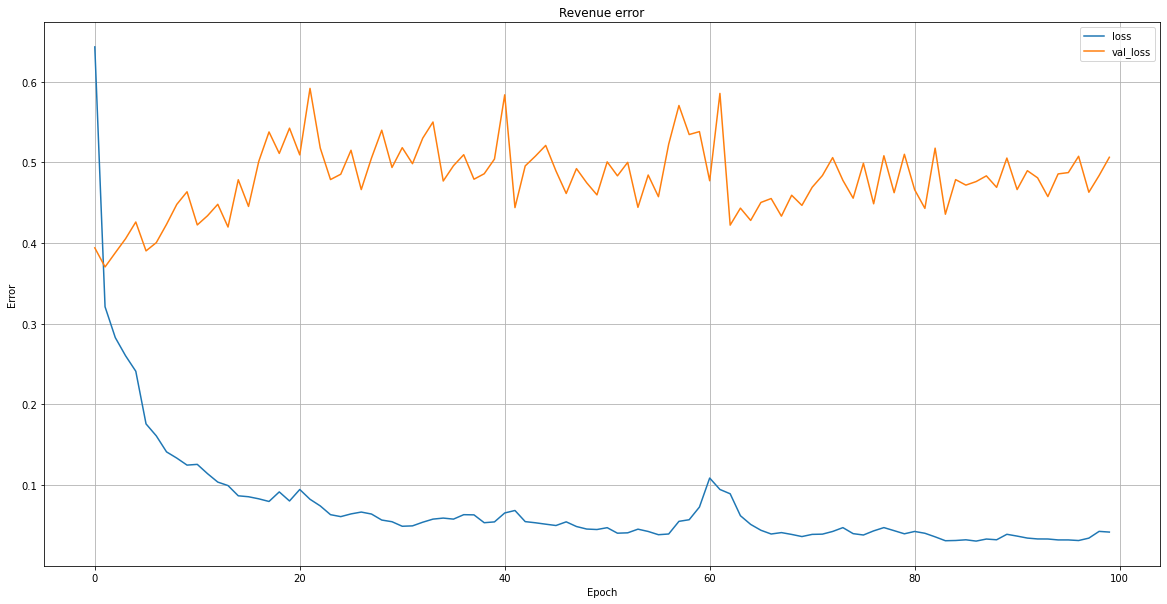

In [ ]:
def plot_loss(history1):
  plt.figure(figsize=(20,10))
  plt.plot(history1.history['loss'], label='loss')
  plt.plot(history1.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.title('Revenue error')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
 
plot_loss(history1)

In [ ]:
predictions = regression_model2.predict(test_x2).flatten()

model2_r2=r2_score(test_y2,predictions)
model2_MAE=mean_absolute_error(test_y2,predictions)
model2_RMSE=mean_squared_error(test_y2,predictions,squared=False)
print(model2_r2,model2_MAE,model2_RMSE)

0.37211115181647003 0.3710968935040077 0.6566898763423676


In [ ]:
xgb_r = xg.XGBRegressor() 
xgb_r.fit(train_x2, train_y2) 
y_pred = xgb_r.predict(test_x2) 
print('MAE=',mean_absolute_error(test_y2,y_pred))
print('RMSE=',mean_squared_error(test_y2,y_pred,squared=False))
print("score",r2_score(test_y2,y_pred))
r2_xgb=r2_score(test_y2,y_pred)
MAE_xgb=mean_absolute_error(test_y2,y_pred)
RMSE_xgb=mean_squared_error(test_y2,y_pred,squared=False)



In [ ]:
model = RandomForestRegressor()
model.fit(train_x2,train_y2)

y_pred = model.predict(test_x2)
print('MAE=',mean_absolute_error(test_y2,y_pred))
print('RMSE=',mean_squared_error(test_y2,y_pred,squared=False))
print("score",r2_score(test_y2,y_pred))
r2_randomforest=r2_score(test_y2,y_pred)
MAE_randomforest=mean_absolute_error(test_y2,y_pred)
RMSE_randomforest=mean_squared_error(test_y2,y_pred,squared=False)



Conclusion

Performing regression using very small number of features in dataset lead to model underfit. In help comes feature engineering but this method is very sophisticated and need very good,analitical way of thinking. I wanted to perform that task even if it was my first time using feature engineering.After comparing models with 3 independent variables and  with more than 100 using feature engineering I can say that the model performed slightly better but still there is a lot to do with optimizatiion and making new feature. 